# ESC Model Optimization

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import control as ct
from pytz import timezone

import sys
sys.path.append('../../../')

from utils.plot import config_matplotlib, figsize, fig_save_and_show, plot_events_data, plot_efficiency_map_scattered
from utils.control import get_steady_state_map
from utils.optimization import MyOptimizationProblem, convert_to_model_params, plot_optimization_params, plot_optimization_error, plot_compare, compute_metrics, save_model_params_to_json, load_model_params_from_json
from utils.data import get_events, get_sections, load_df, process_df, export_dataframe_to_latex
from utils.sensitivity_analysis import describe_param_with_uniform_distribution, describe_param_with_log_uniform_distribution, describe_param_with_triangular_distribution, describe_param_with_normal_distribution, describe_param_with_truncated_normal_distribution, describe_param_with_log_normal_distribution, wrapped_model_function, create_problem_spec_and_sample, plot_sampled_distribuitions, evaluate_problem, analyze_time_step, analyze_problem, sobol_sensitivity_analysis_from_model_params_to_outputs, plot_sensitivity_analysis, plot_sensitivity_analysis_heatmaps, get_region_mean, plot_sensitivity_analysis_bars

import warnings
warnings.filterwarnings("ignore")

config_matplotlib()
latex_img_path = '/home/joaoantoniocardoso/workspace_TCC/repo/tcc/imgs/'
latex_tex_path = '/home/joaoantoniocardoso/workspace_TCC/repo/tcc/tex/'

In [2]:
df = pd.read_csv("data/mam17_test_data.csv") # 50% duty-cycle

df = df.iloc[1:].rename(columns={
    "Io": "esc_i_out",
    "Vo": "esc_v_out",
    "Ii": "esc_i_in",
    "Vi": "esc_v_in",
})

df['esc_d'] = 0.5
df['esc_p_in'] = df['esc_i_in'] * df['esc_v_in']
df['esc_p_out'] = df['esc_i_out'] * df['esc_v_out']
df['esc_eta'] = df['esc_p_out'] / df['esc_p_in']
df['esc_eta'] = df['esc_eta'].fillna(value=0)

# Organize the data for the fit:
#  - Since there's no dynamics involved, we can make up that each measurement were made at each 60 seconds
time = np.linspace(0, len(df)*60, len(df), dtype='timedelta64[s]')
df['time'] = time
df = df.reset_index(drop=True).set_index('time')
df['t'] = time.astype(np.float64)*1e-9  # Simulation time in seconds as floats
df

,esc_i_in,esc_i_out,esc_v_in,esc_v_out,esc_d,esc_p_in,esc_p_out,esc_eta,t
time,,,,,,,,,
0 days 00:00:00,5.4,7.8,35.4,22.2,0.5,191.16,173.16,0.905838,0.000000e+00
0 days 00:01:10,17.1,29.9,33.0,16.5,0.5,564.30,493.35,0.874269,7.000000e-08
0 days 00:02:20,26.1,45.2,32.1,15.9,0.5,837.81,718.68,0.857808,1.400000e-07
0 days 00:03:30,32.9,59.2,31.1,15.2,0.5,1023.19,899.84,0.879446,2.100000e-07
0 days 00:04:40,41.4,74.6,30.3,14.5,0.5,1254.42,1081.70,0.862311,2.800000e-07
0 days 00:05:50,47.9,87.9,25.5,11.7,0.5,1221.45,1028.43,0.841975,3.500000e-07
0 days 00:07:00,55.0,106.4,22.1,9.6,0.5,1215.50,1021.44,0.840346,4.200000e-07


In [3]:
from model import ESC

ESC.build({})

<NonlinearIOSystem esc: ['esc_v_in', 'esc_i_out', 'esc_d'] -> ['esc_v_out', 'esc_i_in']>

In [4]:
esc_operation_params = {
    # ============================================================
    # OPERATION PARAMETERS
    # ============================================================
    "esc_F_s": 12550,         # Hz, switching frequency
    "esc_V_ds_ov": 2.0,       # fractional overshoot (2 → +200 % !! verify intended scale)
}
esc_mosfet_params = {
    # ============================================================
    # MOSFET PARAMETERS (IXFN420N10T)
    # ============================================================
    # Rds(on) at ~100°C (datasheet derived)
    "esc_R_ds_on": 3.7e-3,    # Ohm

    # Switching energies (datasheet-based approximation)
    "esc_E_on":  70e-6,      # J
    "esc_E_off": 110e-6,     # J

    # Body diode conduction
    "esc_V_F": 1.2,          # V   forward drop
    "esc_r_D": 7.5e-3,       # Ohm slope resistance

    # Body diode reverse recovery
    "esc_Q_rr": 0.38e-6,      # C
    # trr not needed by your model, so not included
}
esc_diode_params = {
    # ============================================================
    # DIODE PARAMETERS (DSEI2x101-12A)
    # ============================================================

    "esc_V_F":  1.87,      # V
    "esc_r_D":  3.05e-3,   # Ohm
    "esc_Q_rr":  0.19e-6,   # C
}
esc_params = esc_operation_params | esc_mosfet_params | esc_diode_params
esc_params

{'esc_F_s': 12550,
 'esc_V_ds_ov': 2.0,
 'esc_R_ds_on': 0.0037,
 'esc_E_on': 7e-05,
 'esc_E_off': 0.00011,
 'esc_V_F': 1.87,
 'esc_r_D': 0.00305,
 'esc_Q_rr': 1.9e-07}

In [5]:
from sklearn.preprocessing import RobustScaler, MinMaxScaler, StandardScaler
from pymoo.optimize import minimize
from pymoo.algorithms.soo.nonconvex.nelder import NelderMead
from pymoo.algorithms.soo.nonconvex.pso import PSO
from pymoo.algorithms.soo.nonconvex.isres import ISRES
from pymoo.algorithms.soo.nonconvex.es import ES
from pymoo.algorithms.soo.nonconvex.de import DE
from pymoo.algorithms.soo.nonconvex.g3pcx import G3PCX
from pymoo.algorithms.soo.nonconvex.pattern import PatternSearch
from pymoo.operators.sampling.lhs import LHS
from pymoo.termination.default import DefaultSingleObjectiveTermination
from pymoo.parallelization.starmap import StarmapParallelization
from multiprocessing.pool import ThreadPool
from multiprocessing import Pool


def model_function(T, U, X0, **params):
    Y = ct.input_output_response(
        ESC.build(params=params),
        T=T,
        U=U,
        X0=X0,
        solve_ivp_method='Radau',
    ).to_pandas()

    Y['esc_p_in'] = Y['esc_i_in'] * Y['esc_v_in']
    Y['esc_p_out'] = Y['esc_i_out'] * Y['esc_v_out']
    Y['esc_eta'] = Y['esc_p_out'] / Y['esc_p_in']
    Y['esc_eta'] = Y['esc_eta'].fillna(value=0)

    return Y

n_gen  |  n_eval  |     f_avg     |     f_min    
     1 |     3000 |  0.2087572638 |  0.0376003618
     2 |     6000 |  0.0769413337 |  0.0375932381
     3 |     9000 |  0.0490579350 |  0.0375899070
     4 |    12000 |  0.0411099154 |  0.0375893768
     5 |    15000 |  0.0385482606 |  0.0375889630
     6 |    18000 |  0.0379108829 |  0.0375888777
     7 |    21000 |  0.0377040420 |  0.0375888777
     8 |    24000 |  0.0376360699 |  0.0375888412
     9 |    27000 |  0.0376110261 |  0.0375888412
    10 |    30000 |  0.0375975709 |  0.0375888412
    11 |    33000 |  0.0375929382 |  0.0375888412
    12 |    36000 |  0.0375906912 |  0.0375888407
    13 |    39000 |  0.0375896915 |  0.0375888407
    14 |    42000 |  0.0375892768 |  0.0375888407
    15 |    45000 |  0.0375890360 |  0.0375888407
    16 |    48000 |  0.0375889303 |  0.0375888407
    17 |    51000 |  0.0375888817 |  0.0375888407
    18 |    54000 |  0.0375888614 |  0.0375888407
    19 |    57000 |  0.0375888501 |  0.0375888407


{'esc_R_ds_on': 0.0037, 'esc_V_F': 1.87, 'esc_r_D': 0.00305}

Best parameters found:


{'esc_R_ds_on': 0.008256754167097705,
 'esc_V_F': 3.338359854985,
 'esc_r_D': 0.004027165799996619}

Objective value at solution: [0.03758884]


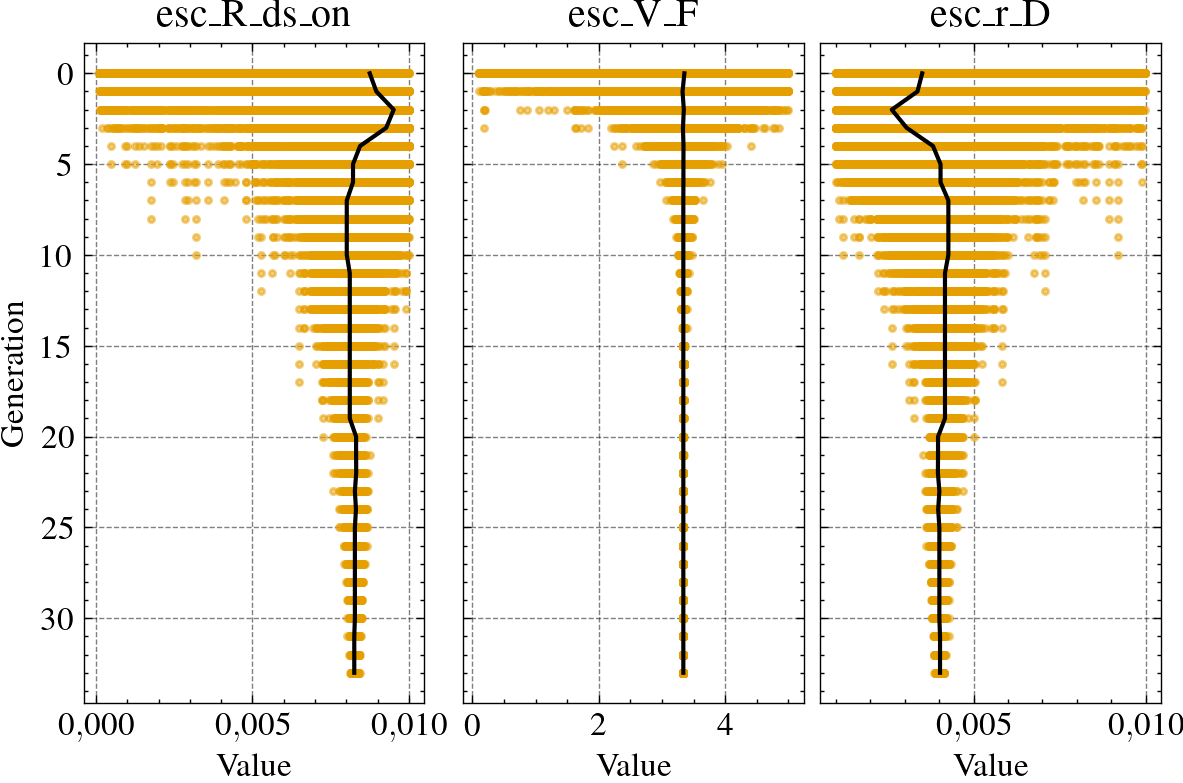

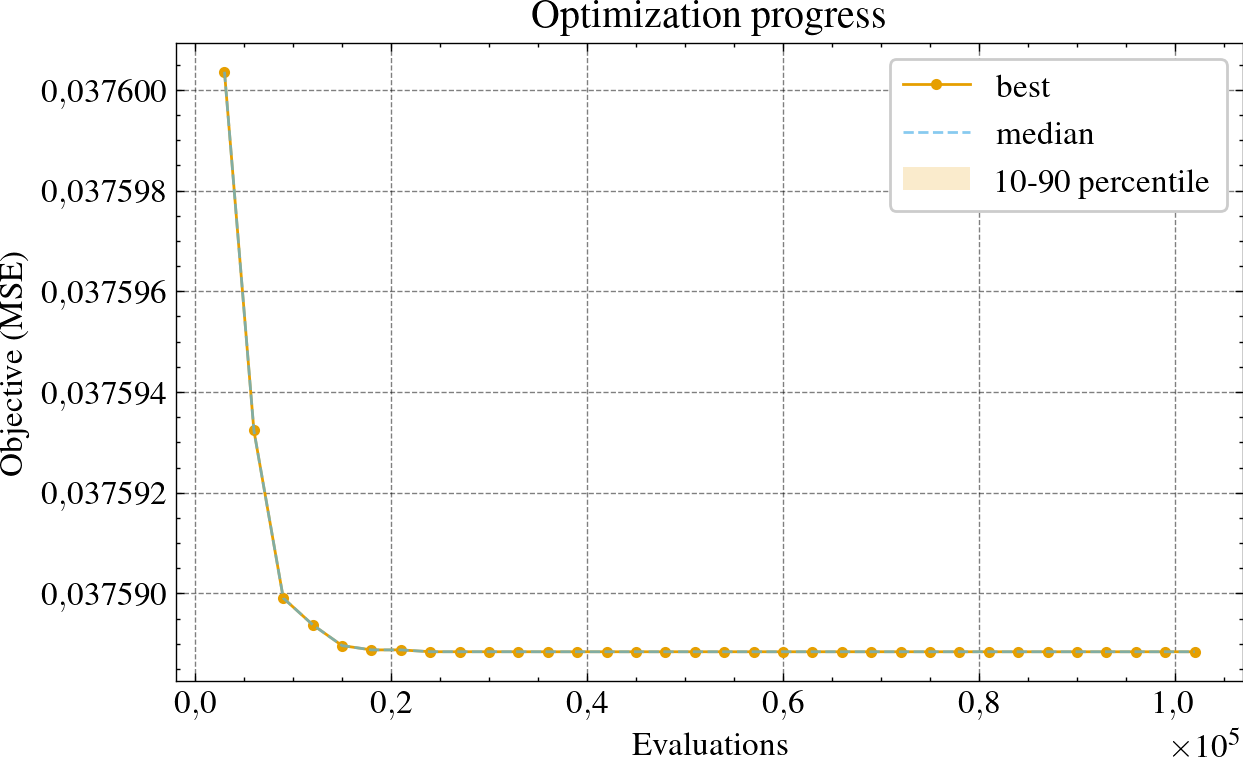

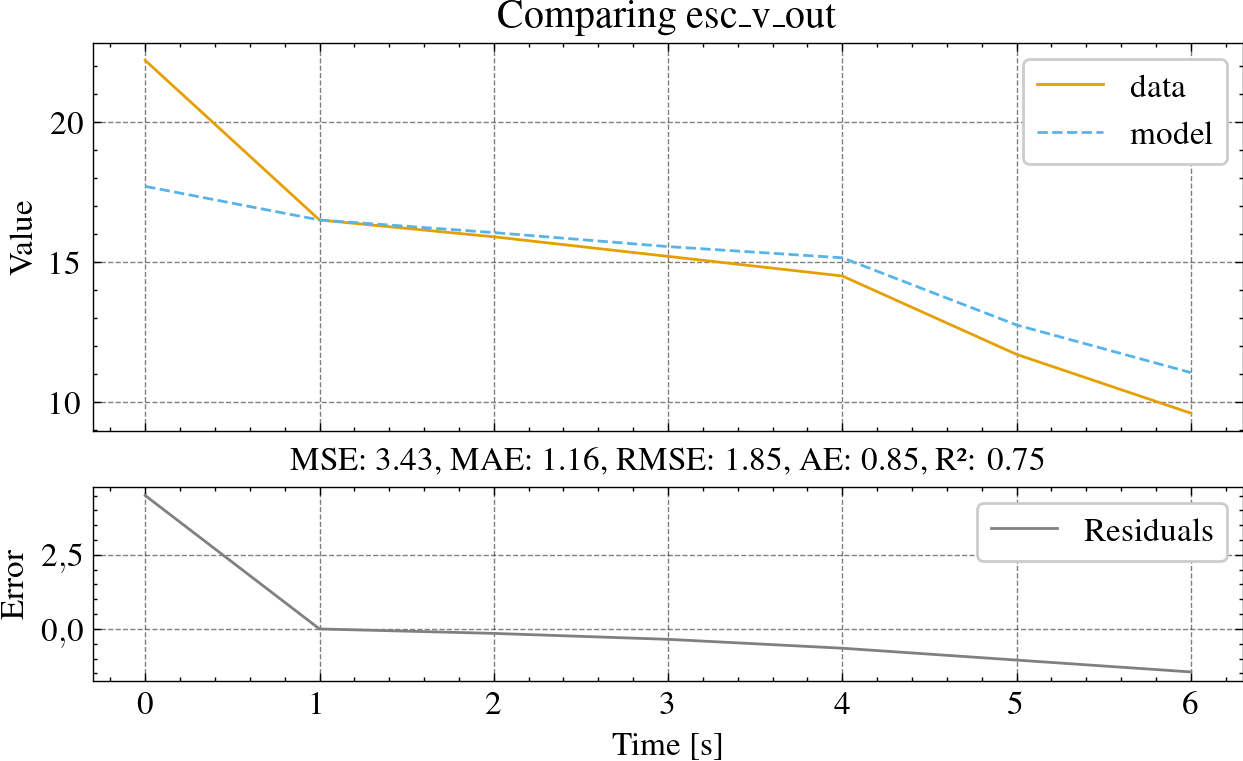

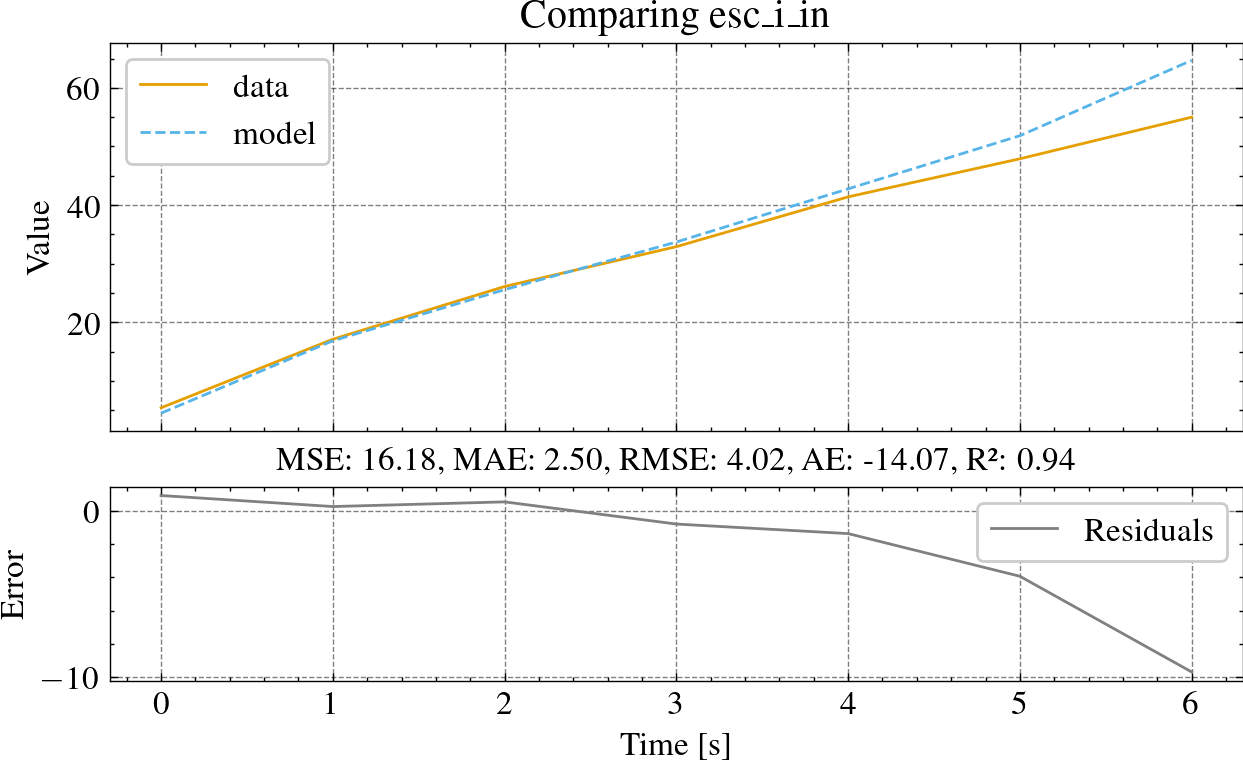

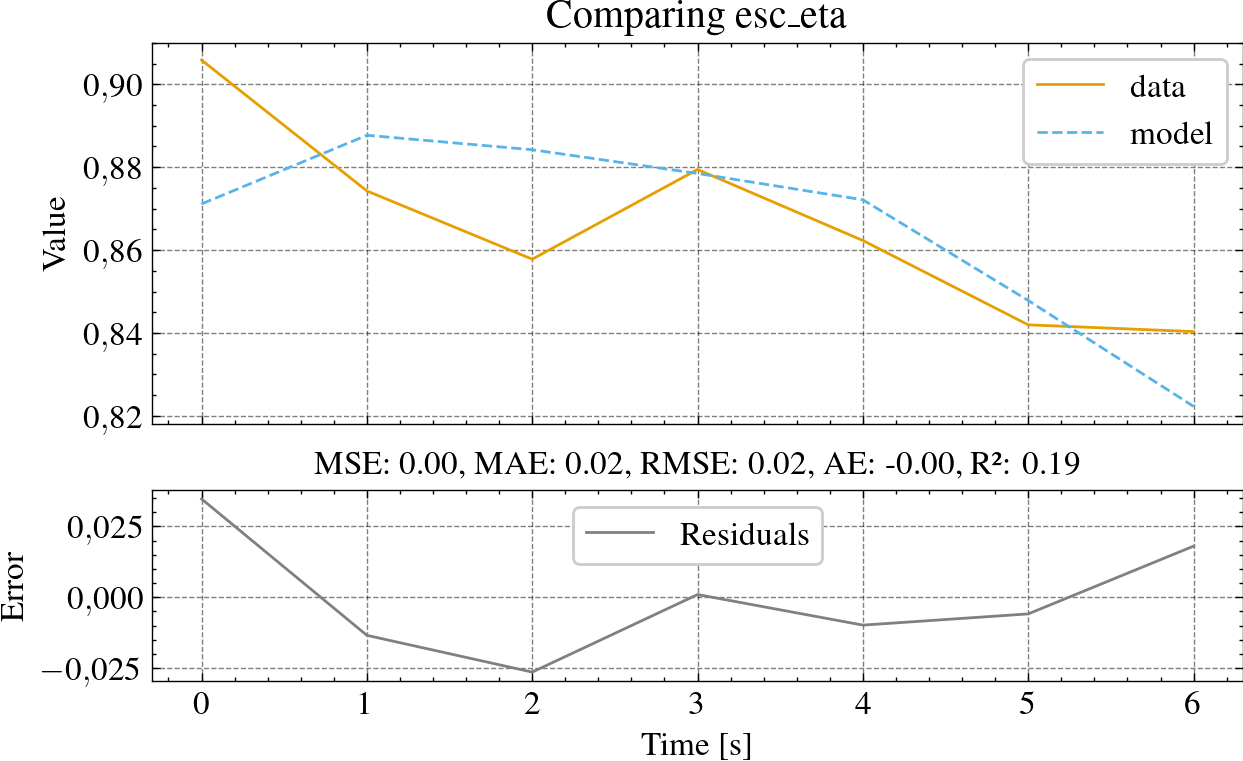

In [6]:
# Select the optimization data
data_cols = ['esc_v_out', 'esc_i_in', 'esc_eta']
input_cols = ['esc_v_in', 'esc_i_out', 'esc_d']

# Put simulation data into df
df_train = df.copy(deep=True)[['t'] + data_cols + input_cols]

# Set model states initial conditions
input_initial_state = {}

# Initialize Parameters
params_bounds = {
    'esc_R_ds_on':dict(min=1e-4,max=1e-2),
    # 'esc_E_on': dict(min=1e-9,max=1e-3),
    # 'esc_E_off':dict(min=1e-9,max=1e-3),
    'esc_V_F':dict(min=1e-1,max=5),
    'esc_r_D':dict(min=1e-3,max=1e-2),
    # 'esc_Q_rr': dict(min=1e-12,max=1e-6),
}

# Initialize the thread pool and create the runner
n_processes = 32
pool = Pool(processes=n_processes)
runner = StarmapParallelization(pool.starmap)

try:
    # Initialize the problem
    model = ESC
    model_params = esc_params.copy()
    problem = MyOptimizationProblem(
        model=model,
        model_function=model_function,
        training_data=df_train,
        training_data_columns=data_cols,
        model_params=model_params,
        opt_params_bounds=params_bounds,
        input_initial_state=input_initial_state,
        input_columns=input_cols,
        data_scaler=MinMaxScaler,
        elementwise_runner=runner,
        print_exceptions=True,
    )

    algorithm = DE(
        pop_size=1000*len(params_bounds),
        sampling=LHS(),
        variant="DE/best/1/bin",
        F=0.5,
        CR=0.9,
    )

    # Specify termination criteria (optional)
    termination = DefaultSingleObjectiveTermination(
        xtol=1e-8,
        cvtol=1e-6,
        ftol=1e-6,
        period=100,
        n_max_gen=1000,
        n_max_evals=100000
    )

    # Run the optimization
    result = minimize(
        problem,
        algorithm,
        termination=termination,
        seed=42,
        verbose=True,
        save_history=True,
    )
    print('Threads:', result.exec_time)
finally:
    pool.close()
    pool.join()

# Print the results
best_params = convert_to_model_params({k: result.X[i] for (i, k) in enumerate(params_bounds.keys())})
original_params = {k: convert_to_model_params(model_params)[k] for k in best_params.keys()}
print("Original parameters were:")
display(original_params)
print("Best parameters found:")
display(best_params)
print("Objective value at solution:", result.F)

plot_optimization_params(result, params_bounds)
plot_optimization_error(result)

T = np.ascontiguousarray(df_train['t'].to_numpy())
U = np.ascontiguousarray(df_train[input_cols].to_numpy().T)
X0 = model.initial_state(X0=input_initial_state, U0=U[:,0], params=model_params | best_params)

best_fit_data = model_function(T, U, X0, **(model_params | best_params))

for col in data_cols:
    plot_compare(df, best_fit_data, col)


In [7]:
params_output_path = 'mam17_params.json'
save_model_params_to_json(params_output_path, model_params | best_params)
loaded_params = load_model_params_from_json(params_output_path)
loaded_params
        

{'esc_E_off': 0.00011,
 'esc_E_on': 7e-05,
 'esc_F_s': 12550,
 'esc_Q_rr': 1.9e-07,
 'esc_R_ds_on': 0.008256754167097705,
 'esc_V_F': 3.338359854985,
 'esc_V_ds_ov': 2.0,
 'esc_r_D': 0.004027165799996619}

In [8]:
model_params | best_params

{'esc_F_s': 12550,
 'esc_V_ds_ov': 2.0,
 'esc_R_ds_on': 0.008256754167097705,
 'esc_E_on': 7e-05,
 'esc_E_off': 0.00011,
 'esc_V_F': 3.338359854985,
 'esc_r_D': 0.004027165799996619,
 'esc_Q_rr': 1.9e-07}

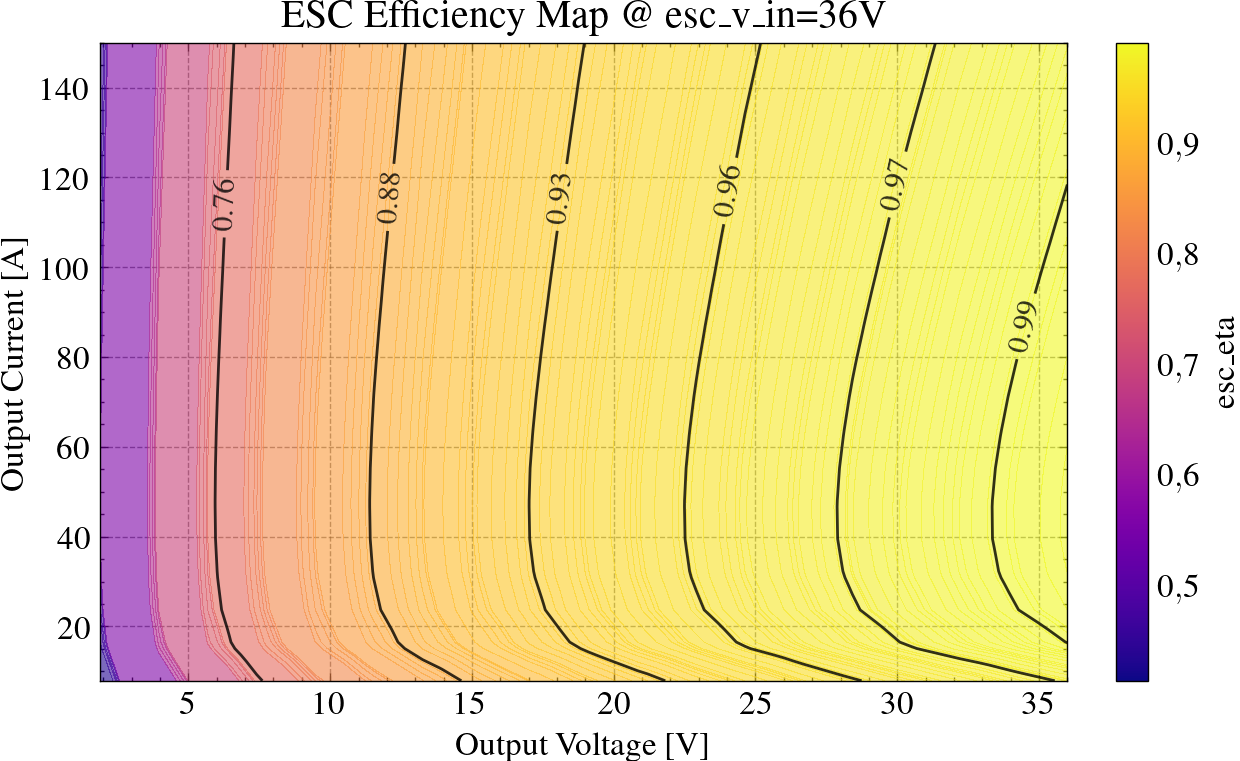

In [9]:
Y_ss = get_steady_state_map(
    model_class=ESC,
    model_function=model_function,
    model_params=esc_params,
    sweep_bounds={
        'esc_v_in': dict(min=36, max=36),
        'esc_i_out': dict(min=0, max=150),
        'esc_d': dict(min=0, max=1),
    },
    sweep_steps=20,
    dt=1,
    ss_len=2,
    ss_tail_len=1,
)

fig, ax, out = plot_efficiency_map_scattered(
    Y_ss,
    x='esc_v_out', y='esc_i_out', z='esc_eta',
    nx=100, ny=100,
    mask_col='esc_p_out', mask_min=0,
    level_pmin=0, level_pmax=100, level_n=100,
    contour_lines=True,
    line_pmin=0, line_pmax=95, line_n=7,
    line_colors='k',
    label_lines=1,
    title='ESC Efficiency Map @ esc_v_in=36V',
    xlabel='Output Voltage [V]',
    ylabel='Output Current [A]',
    cmap='plasma',
    fill_alpha=0.6,
)
plt.show()